<a href="https://colab.research.google.com/github/yasamanasgarii/Computer-vision/blob/main/Poisson%20Blending.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poisson blending 


---
In this problem, we explain the intuition behind an image processing technique called** Poisson Blending**. This technique is an image processing operator that allows the user to insert one image into another, without introducing any visually unappealing seams. Furthermore, this technique also makes sure that the color of the inserted image is also shifted, so that the inserted object feels as if it is part of the environment of the target image. So a bright object copy-and-pasted into a rather dark image, will have its color shifted to a darker color



I'm going to follow instructions of this [link ](http://cs.brown.edu/courses/cs129/results/proj2/taox/).
and the lectures of the class.

### Importing libraries.
We first import libraries. The needed ones are:
1. CV2
2. Numpy as np 
3. path for saving 
4. scipy. parse


In [ ]:
import cv2
import numpy as np
from os import path
import scipy.sparse
import PIL.Image


###Preprocess Source, Target, and Mask images
The mask and source images are first padded so that they are the same size as the target image. Next, they are translated using parameterized row/column offsets. If the valid pixels in the mask are on the edge of the source image, a 1 pixel symmetric buffer is added to all 3 images to make processing easier. This 1 pixel buffer is then cropped off later from the result.

#### **Function** : make_mask_png
The arguments are:
1. Source Image
2. Target Image
3. offset

---



 As we know and I explained in the second homework each PNG photo has 4 channels. \
 The channels are:
 * Red, Blue, Green as Jpeg 
 * Alpha


---

**Alpha**: A channel that shows whether there is background or forground.When it has the value 255 it shows that it's foreground and when it has the value 0 it's background.\
So by default it's a binary mask that we can use easily for our work.\
To make binary mask with same size of the photo we should have an offset: Offset means that the pasted photo initial location.\
So we paste the value of alpha in the target image. for better result we apply a morphology function named erosion to reduce the edges of the mask and we save it finally.

---

We use:


```
cv2.split(image)
```

for spliting the channels of png to 4 channels explained.\

We use this code for erosion:


```
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(image,kernel,iterations = 1)
```
It has a kernel that is going to be applied on the image.



In [ ]:
def make_mask_png(image_src , image_target , offset):
  mask=np.zeros((image_target.shape))
  r  , g , b , alpha = cv2.split(image_src)
  for j in np.arange(offset[0] , offset[0]+alpha.shape[1],1):
    for i in np.arange(offset[1],offset[1]+alpha.shape[0],1):
      mask[i][j][:]=alpha[i-offset[1]][j-offset[0]]
  kernel = np.ones((5,5),np.uint8)
  dilation = cv2.dilate(mask,kernel,iterations = 3)
  #erosion = cv2.erode(mask,kernel,iterations = 1)
  
  return dilation

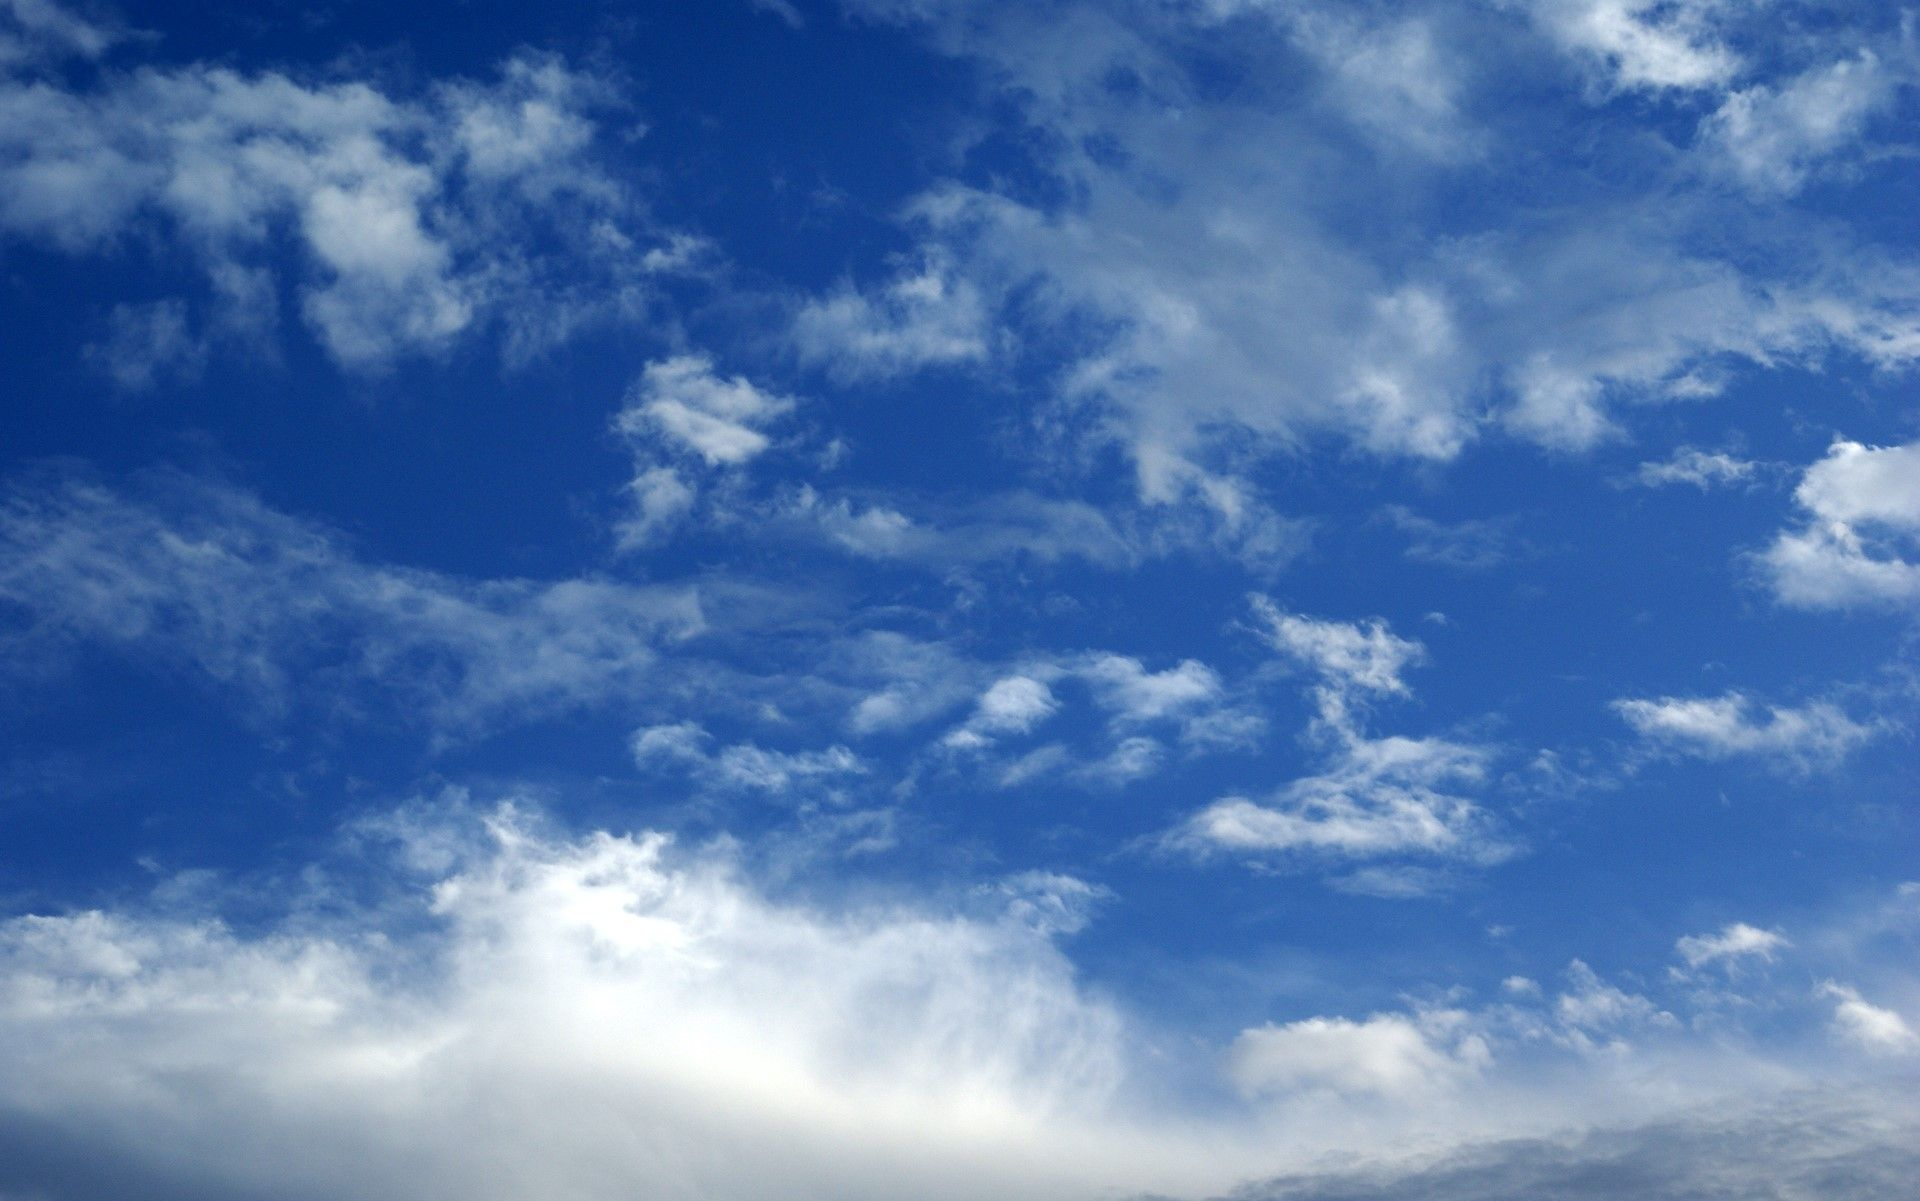

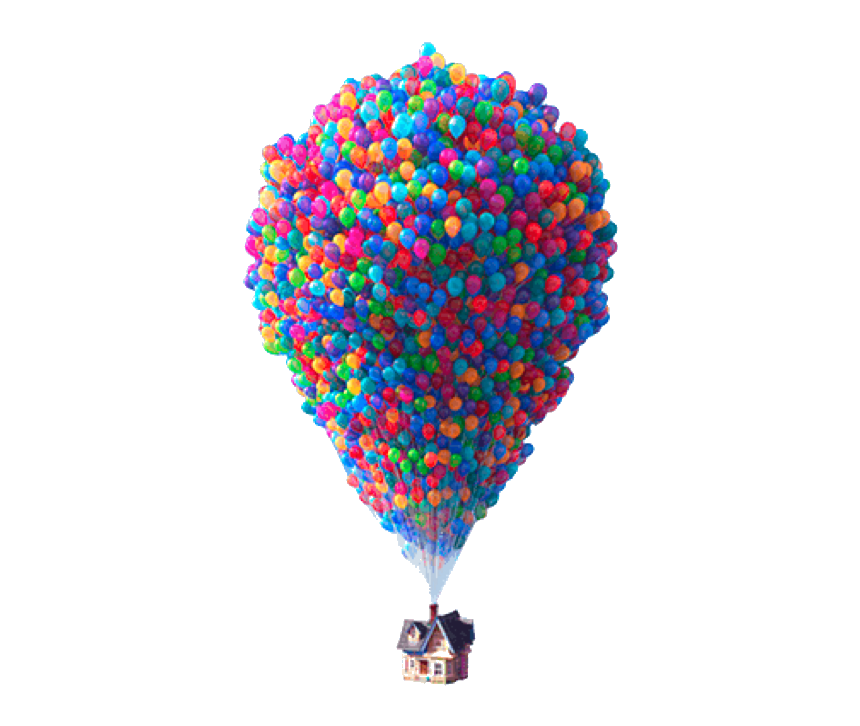

#### **Function** : prepare_source
The arguments are:
1. Source Image(this should have 3 channels)
2. Target Image
3. offset

---

We paste the data of source in a special place(offset) of target image.\
To do this work we for in x , y directions in a zero matrix same size of target image.\
Then we replace it by the proper value in the correct locations.


In [ ]:
def prepare_source(image_src_3channel , image_target , offset):
  new_tar=np.zeros((image_target.shape))
  for j in np.arange(offset[0] , offset[0]+image_src_3channel.shape[1],1):
    for i in np.arange(offset[1],offset[1]+image_src_3channel.shape[0],1):
        new_tar[i][j][:]=image_src_3channel[i-offset[1]][j-offset[0]][:]
  return new_tar

#### **Function** : prepare_mask
The argument is the mask which as array.


---

This function is going to get the values if each directions x ,y.
with command:


```
width , height = image.shape
```

To do this work we *for* in x , y directions in a zero matrix same size of target image.But this time the matrix is a binary mask and it doesn't have 3 channels.\
if the values in each index has sum more than zero it should be 255 or 1. 

In [ ]:
def prepare_mask(mask):
  width , height,_ = mask.shape
  result = np.zeros((width, height), dtype=np.uint8)
  for i in range(width):
      for j in range(height):
          if sum(mask[i][j]) > 0:
              result[i][j] = 1
  return result

##Generate a Sparse Matrix
A linear system of equations is required to compute the resulting image from the source and target gradients. This system is represented by Ax=b, where A is the sparse coefficients matrix, x is the output image, and b is the desired gradient matrix. The size of sparse matrix A is NxN, where N is target image rows multipled by target image columns.

For pixels outside the masked region, the output image pixel is simply the same as the target image. For these pixels, the row in the sparse matrix A is simply the same as the identity matrix. Also for these pixels, the corresponding value in the desired pixel gradient matrix b are also the same pixel value as the target image.

For pixels inside the masked region, the output image pixel x at (row, col) depends on its neighbors according to the following equation:\

4*x(row, col) - x(row+1, col) - x(row-1, col) - x(row, col+1) - x(row, col-1) = desired pixel gradient\

For these pixels inside the masked region, the row in the sparse matrix then contains these coefficients at the corresponding indices. The value of the desired pixel gradient is in matrix b and is described further in the Mixing Gradients section.

The creation of this sparse matrix was also optimized by eliminating most of the for loops

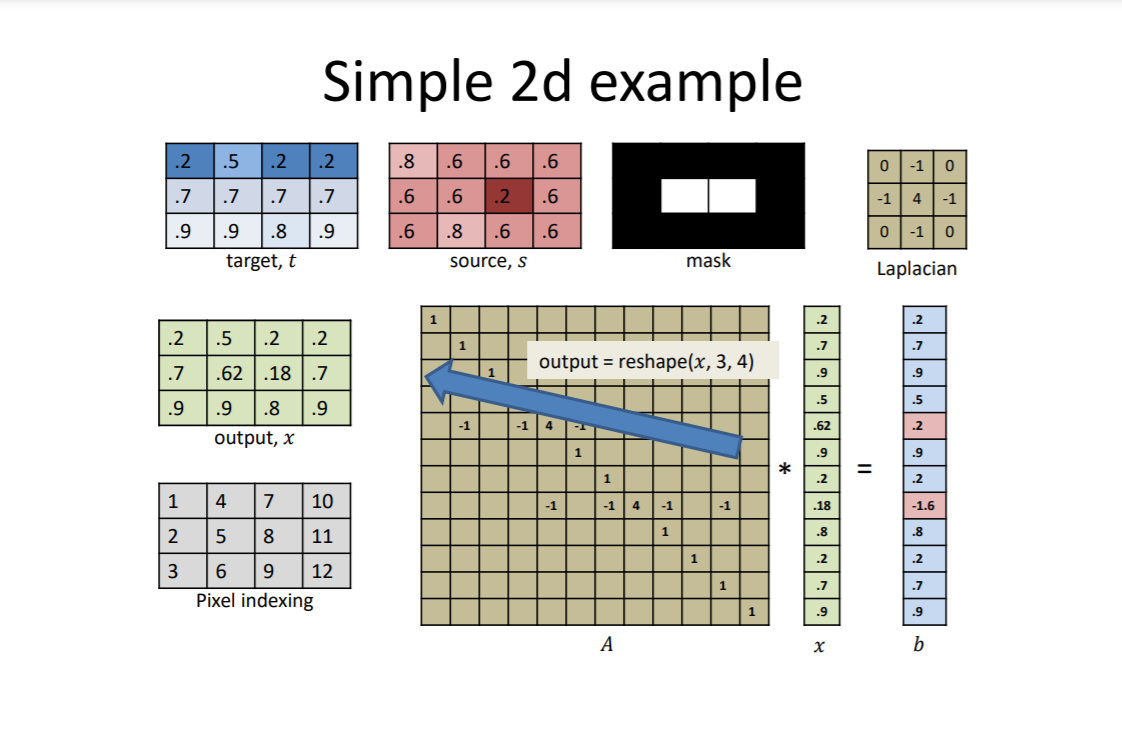

#### **Function** : get_regions
The arguments are:
1. Source Image(this should have 3 channels)
2. Target Image
3. offset


---
We are going to find the window wich is specified by the offset and the images.\
It's not that hard to understand this.
we get height and width of image and pay attention to overlapping.\
My images have the same size but i think it's good to do for differnet offsets.



In [ ]:
def get_regions(img_target, img_source, img_mask, offset=(0, 0)):
    width_s, height_s , _=img_source.shape
    width_t, height_t,_=img_target.shape
    region_source = (
            max(-offset[0], 0),
            max(-offset[1], 0),
            min(width_t-offset[0], width_s),
            min( height_t-offset[1], height_s))
    
    region_target = (
            max(offset[0], 0),
            max(offset[1], 0),
            min(width_t, width_s+offset[0]),
            min( height_t, height_s+offset[1]))
    
    region_size = (region_source[2]-region_source[0], region_source[3]-region_source[1])
    return region_source,region_target,region_size


#### **Function** : creat_coefficient_matrix
The arguments are:
1. img_mask
2. region_size


---
For pixels inside the masked region, the output image pixel x at (row, col) depends on its neighbors according to the following equation:\
4*x(row, col) - x(row+1, col) - x(row-1, col) - x(row, col+1) - x(row, col-1) = desired pixel gradient\
For these pixels inside the masked region, the row in the sparse matrix then contains these coefficients at the corresponding indices. 

In [ ]:
def creat_coefficient_matrix(img_mask, region_size):
    A = scipy.sparse.identity(np.prod(region_size), format='lil')
    for y in range(region_size[0]):
        for x in range(region_size[1]):
            if img_mask[y,x]:
                index = x+y*region_size[1]
                A[index, index] = 4
                if index+1 < np.prod(region_size):
                    A[index, index+1] = -1
                if index-1 >= 0:
                    A[index, index-1] = -1
                if index+region_size[1] < np.prod(region_size):
                    A[index, index+region_size[1]] = -1
                if index-region_size[1] >= 0:
                    A[index, index-region_size[1]] = -1
    A = A.tocsr()
    return A

#### **Function** : make_correct_mask
The arguments are:
1. img_mask
2. region


---
We are going to check the mask is in the window or not.\
We should make a region with true and false.
* if it's equal to 0 we shouldn't get from the source so **False**
* if it's equal to 1 we should get from the source so **True**

In [ ]:
def make_correct_mask(img_mask, region):
    img_mask = img_mask[region[0]:region[2], region[1]:region[3]]
    img_mask = prepare_mask(img_mask)
    img_mask[img_mask==0] = False
    img_mask[img_mask!=False] = True
    return img_mask

#### **Function** : flatten_image_channel
The arguments are:
1. image
2. region
3. channel


---

this function attaches the matrix to getter:


```
line = matrix.flatten()
```


But note that you should only linearize the matrix in the region in a specified channel.

In [ ]:
def flatten_image_channel(image , channel , region_size):
  temp= image[region_size[0]:region_size[2],region_size[1]:region_size[3],channel]
  temp = temp.flatten()
  return temp

#### **Function** : make_b_matrix
The arguments are:
1. img_mask
2. region_size
3. flatten_imgs = a list contains flattened source and target.
4. poisson


---
The value of the desired pixel gradient is in matrix b and is described further in the Mixing Gradients section.\
it's explained in the class that we should index well the locations and if it's from target matrix we should bring them in our matrix. the result is also a linear one.


In [ ]:
def make_b_matrix(img_mask , region_size , flatten_imgs , poisson):
  s, t = flatten_imgs
  width , height=region_size
  b = poisson * s
  for y in range(width):
      for x in range(height):
          if not img_mask[y,x]:
              index = x+y*height
              b[index] = t[index]
  return b

##Blend Each Color Channel Separately
Finally, each image's red, green, and blue color channels are blended separately. While the same sparse coefficients matrix A may be used for each color channel, the gradient matrix b is different for each color channel.

The final output is calculated using the matrix operation x = A\b 

I used pyamg for poisson solving. It's not that much hard because the basis is scipy and pandas.

In [ ]:
pip install pyamg
import pyamg

In [ ]:
def blend(img_target, img_source, img_mask, offset=(0, 0)):
    # decide for the region
    region_source,region_target,region_size=get_regions(img_target, img_source, img_mask, offset)
    #make regional mask
    img_mask =make_correct_mask(img_mask , region_source)
    #make coefficent matrix
    A=creat_coefficient_matrix(img_mask, region_size)
    # make poisson matrix
    poisson = pyamg.gallery.poisson(img_mask.shape)
    for channel in range(3):
        # get flatten
        t=flatten_image_channel(img_target , channel , region_target)
        s=flatten_image_channel(img_source , channel , region_source)
        # create b
        b=make_b_matrix(img_mask , region_size , [s, t],poisson)
        # solve Ax = b
        x = pyamg.solve(A,b,verb=False,tol=1e-8)
        # reshape x to target image
        x = np.reshape(x, region_size)
        #check for errors <255 and >0
        x[x>255] = 255
        x[x<0] = 0
        x = np.array(x, img_target.dtype)
        #assign to the matrix
        img_target[region_target[0]:region_target[2],region_target[1]:region_target[3],channel] = x
    return img_target

## Test

In [ ]:
target=cv2.imread('sky.jpg', cv2.IMREAD_COLOR)
source=cv2.imread('up3.png', cv2.IMREAD_UNCHANGED)
source3=cv2.imread('up3.png', cv2.IMREAD_COLOR)

In [ ]:
new_source=prepare_source(source3 , target , offset=(60 , 200))
cv2.imwrite(path.join('', 'new_up.jpg'), new_source)

True

In [ ]:
mask=make_mask_png(source , target , (60, 200))
cv2.imwrite(path.join('', 'mask_up.jpg'), mask)

True

In [ ]:
result = blend(target, new_source, mask, offset=(0,0)) 
cv2.imwrite(path.join('', 'result.jpg'), result)

True

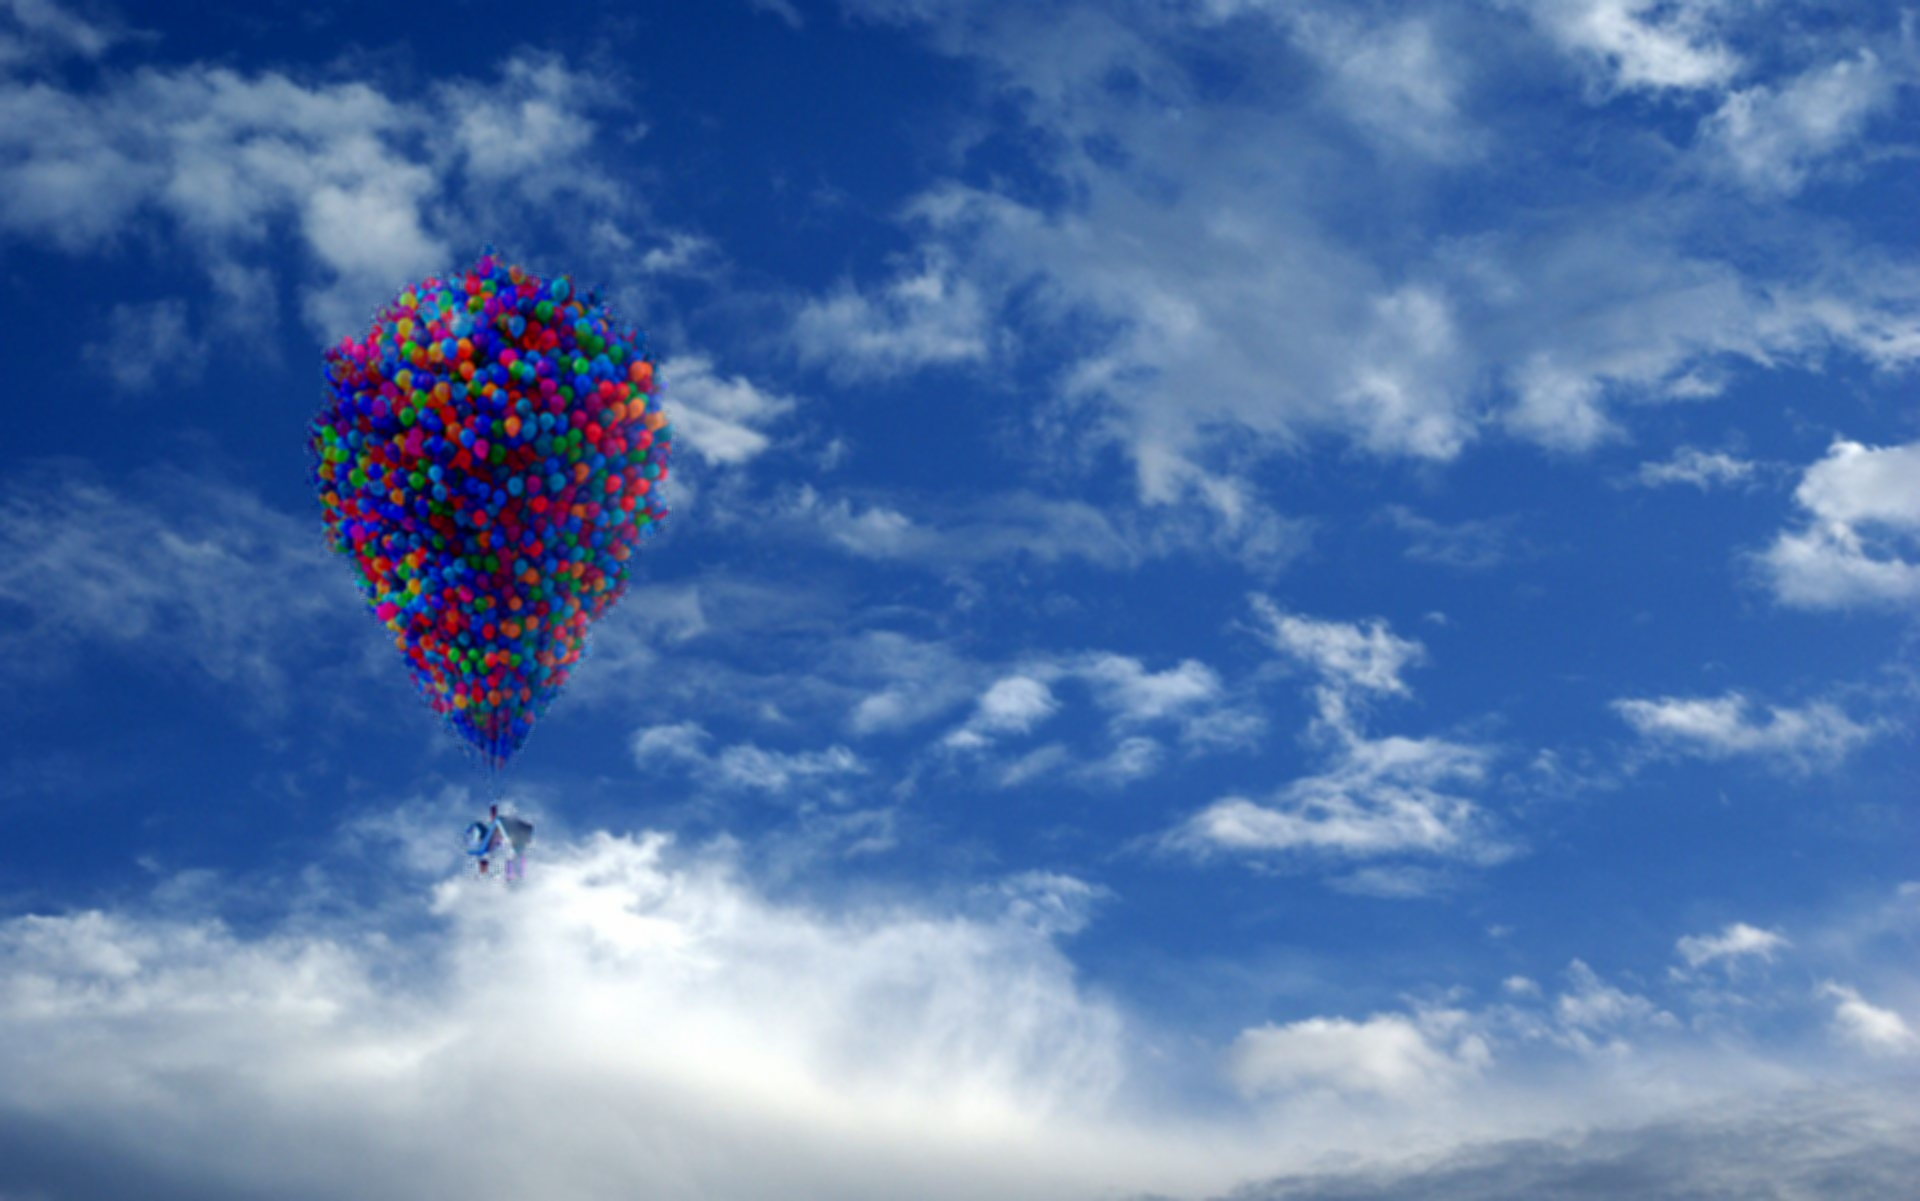